In [1]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follo

In [2]:
from datasets import load_dataset 

train_df = load_dataset("arampacha/rsicd", split="train")
val_df = load_dataset("arampacha/rsicd", split="valid")
test_df = load_dataset("arampacha/rsicd", split="test")

dataset_infos.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/55.1M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/51.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8734 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1093 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1094 [00:00<?, ? examples/s]

In [3]:
train_df

Dataset({
    features: ['filename', 'captions', 'image'],
    num_rows: 8734
})

In [4]:
def expand_with_multiple_captions(batch):
    new_batch = {
        "filename": [],
        "image": [],
        "captions": [],
    }
    for filename, image, captions in zip(batch["filename"], batch["image"], batch["captions"]):
        for caption in captions:
            new_batch["filename"].append(filename)
            new_batch["image"].append(image)
            new_batch["captions"].append(caption)
    return new_batch

train_df = train_df.map(expand_with_multiple_captions, batched=True)
val_df = val_df.map(expand_with_multiple_captions, batched=True)

Map:   0%|          | 0/8734 [00:00<?, ? examples/s]

Map:   0%|          | 0/1094 [00:00<?, ? examples/s]

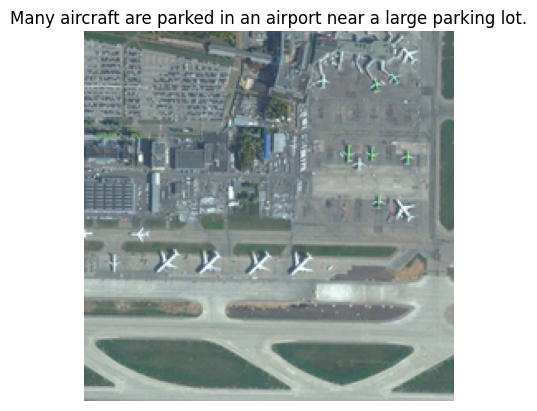

In [5]:
import matplotlib.pyplot as plt

def show_caption_and_img(dataset, ind):
    plt.axis('off')
    plt.imshow(dataset[ind]["image"])
    plt.title(dataset[ind]["captions"])

show_caption_and_img(train_df, 100)
# show_caption_and_img(val_df, 0)
# show_caption_and_img(test_df, 10)

In [6]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["captions"] = item["captions"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "captions":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["captions"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


In [7]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)

2025-06-19 05:30:05.589580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750311006.094853      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750311006.230711      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj", "query", "key"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 6,189,056 || all params: 3,750,868,992 || trainable%: 0.1650


In [9]:
model.device

device(type='cuda', index=0)

In [10]:
train_dataset = ImageCaptioningDataset(train_df, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4, collate_fn=collate_fn)

In [11]:
len(train_dataloader)

10918

In [12]:
print("Train dataset size:", len(train_dataset))
print("Expected batches per epoch:", len(train_dataset) // 4)

Train dataset size: 43670
Expected batches per epoch: 10917


In [13]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

num_epochs = 1

losses = []
indexes = []

for epoch in range(num_epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    # Tracking loss every 10 batches
    if idx % 10 == 0:
        losses.append(loss.item())
        indexes.append(idx)

    # Printing loss every 100 batches
    if idx % 100 == 0:
        print("Loss:", loss.item())
        
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


Loss: 6.2265625
Loss: 1.701171875
Loss: 1.4130859375
Loss: 1.56640625
Loss: 1.4052734375
Loss: 2.083984375
Loss: 1.2294921875
Loss: 1.4091796875
Loss: 1.1015625
Loss: 1.9130859375
Loss: 1.8916015625
Loss: 1.9658203125
Loss: 2.16015625
Loss: 0.87744140625
Loss: 2.30078125
Loss: 1.435546875
Loss: 1.7314453125
Loss: 1.6279296875
Loss: 2.46875
Loss: 1.8330078125
Loss: 2.115234375
Loss: 3.193359375
Loss: 3.365234375
Loss: 2.849609375
Loss: 2.861328125
Loss: 1.8623046875
Loss: 2.279296875
Loss: 3.12890625
Loss: 3.2734375
Loss: 2.5078125
Loss: 2.005859375
Loss: 2.185546875
Loss: 3.263671875
Loss: 2.298828125
Loss: 2.751953125
Loss: 2.20703125
Loss: 1.7080078125
Loss: 2.8203125
Loss: 2.490234375
Loss: 2.498046875
Loss: 1.861328125
Loss: 2.205078125
Loss: 2.189453125
Loss: 2.119140625
Loss: 2.71484375
Loss: 1.7646484375
Loss: 1.7373046875
Loss: 1.9462890625
Loss: 3.23046875
Loss: 3.439453125
Loss: 3.455078125
Loss: 2.962890625
Loss: 2.974609375
Loss: 2.580078125
Loss: 2.3984375
Loss: 2.51757812

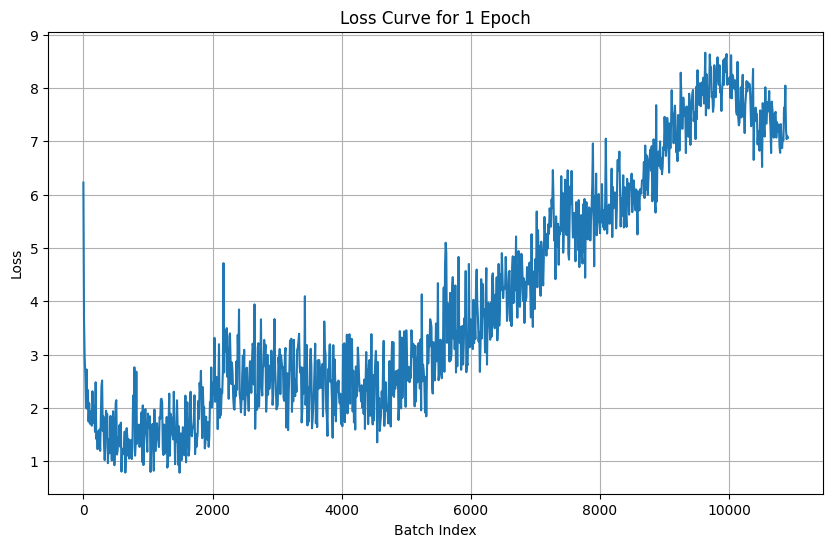

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(indexes, losses)
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Loss Curve for 1 Epoch")
plt.grid(True)
plt.show()


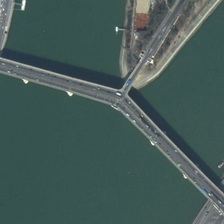

In [15]:
example = val_df[705]
image = example["image"]
image

In [16]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.


È



In [17]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("huggingface") # Replace with your HF token in Kaggle Secrets

In [18]:
from huggingface_hub import login

login(secret_value_0)

In [19]:
!huggingface-cli whoami

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


dhairya-1105


In [20]:
model.push_to_hub("dhairya-1105/blip2-opt-2.7b-rsicd-dataset-qformer")

adapter_model.safetensors:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dhairya-1105/blip2-opt-2.7b-rsicd-dataset-qformer/commit/98a19d0039745642dd44ce468687b61b09f15246', commit_message='Upload model', commit_description='', oid='98a19d0039745642dd44ce468687b61b09f15246', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dhairya-1105/blip2-opt-2.7b-rsicd-dataset-qformer', endpoint='https://huggingface.co', repo_type='model', repo_id='dhairya-1105/blip2-opt-2.7b-rsicd-dataset-qformer'), pr_revision=None, pr_num=None)

In [21]:
from transformers import Blip2ForConditionalGeneration, AutoProcessor
from peft import PeftModel, PeftConfig

peft_model_id = "dhairya-1105/blip2-opt-2.7b-rsicd-dataset"
config = PeftConfig.from_pretrained(peft_model_id)

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit=True, device_map="auto")
model = PeftModel.from_pretrained(model, peft_model_id)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

adapter_config.json:   0%|          | 0.00/910 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

In [22]:
model.device

device(type='cuda', index=0)

The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.


Generated Caption: some buildings are close to a viaduct.
Reference Captions: ['a large number of residential areas are located around the viaduct.', 'The neighborhood is full of big trees.', 'the neighborhood is full of large trees .', 'a large number of residential areas are located around the viaduct.', 'a large number of residential areas are located around the viaduct .']


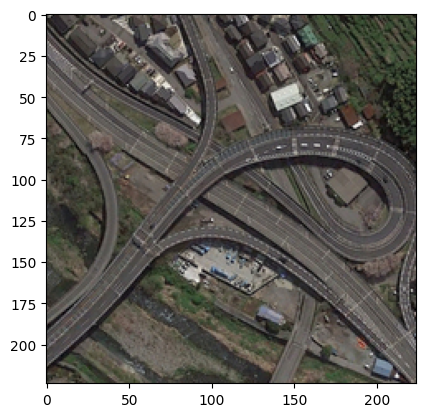

In [23]:
def generate_caption(index, test_df, model, processor, num_beams=5, max_length=50, length_penalty=0):
    import torch
    model.eval()
    device = next(model.parameters()).device

    example = test_df[index]
    image = example["image"]
    plt.imshow(image)
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            pixel_values=inputs["pixel_values"],
            max_length=max_length,
            num_beams=num_beams,
            # length_penalty=length_penalty,
            # early_stopping=True
        )
    
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return caption.strip()

idx = 1000  # Index of the image in test_df
caption = generate_caption(idx, test_df, model, processor)
print(f"Generated Caption: {caption}")
print(f"Reference Captions: {test_df[idx]['captions']}")